In [694]:
###################################
### 0. Preparation
###################################

### Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as ax

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, jaccard_score
from sklearn.model_selection import cross_val_score, validation_curve
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


In [695]:
### Import dataset
df = pd.read_csv("rice_spi_data.csv")
df.head()

,country,hub,yield,profit,nue,pue,TCP,laborinput,elementalN,elementalP,...,qseed,sprice,equipments,domain,certified,useherb,useinect,applyN,applyP,applyK
0,Benin,Glazoue,550.0,-177.0,NaN,NaN,299.6247,143.0,0.0,0.0,...,74.0,0.0,5.0,Lowland,Yes,No,No,No,No,No
1,Benin,Glazoue,500.0,-129.0,60.0,412.0,358.0000,37.0,8.0,1.0,...,74.0,1.0,8.0,Lowland,Yes,Yes,No,Yes,Yes,Yes
2,Benin,Glazoue,2000.0,230.0,59.0,203.0,324.9781,142.0,34.0,10.0,...,50.0,0.0,5.0,Lowland,No,Yes,No,Yes,Yes,Yes
3,Benin,Glazoue,300.0,-477.0,4.0,14.0,530.7132,134.0,85.0,21.0,...,50.0,0.0,5.0,Lowland,No,No,No,Yes,Yes,Yes
4,Benin,Glazoue,300.0,-362.0,14.0,73.0,411.5135,100.0,21.0,4.0,...,60.0,0.0,5.0,Lowland,Yes,No,No,Yes,Yes,Yes


In [696]:
###################################
### 1. Data Preprocessing
###################################

### 1.1 Characterize the dataset
## See all numerical attributes
df.describe()

,yield,profit,nue,pue,TCP,laborinput,elementalN,elementalP,elementalK,laborprod,qseed,sprice,equipments
count,2907.000000,2907.000000,2396.000000,2.128000e+03,2764.000000,2907.000000,2907.000000,2907.000000,2907.000000,2907.000000,2907.000000,2764.000000,2907.000000
mean,2258.969591,391.340718,1314.161742,4.132448e+03,234.845270,89.243930,25.784092,3.144847,5.903482,43.736782,75.554939,0.300283,4.110423
std,2046.672377,595.662329,25953.361580,6.688445e+04,334.058179,57.835483,63.936939,8.255262,14.870469,69.886668,31.452152,0.158215,3.266525
min,100.000000,-3587.800000,0.000000,0.000000e+00,-59.560290,8.000000,0.000000,0.000000,0.000000,1.000000,12.500000,0.000000,0.000000
25%,750.000000,29.500000,0.000000,0.000000e+00,109.204625,36.000000,0.000000,0.000000,0.000000,10.000000,54.000000,0.196864,2.000000
50%,1599.000000,221.000000,14.000000,0.000000e+00,199.000000,80.000000,0.000000,0.000000,0.000000,20.000000,70.000000,0.277778,3.000000
75%,3000.000000,557.500000,117.000000,5.795000e+02,320.128025,137.000000,20.000000,2.000000,3.000000,45.000000,83.333330,0.380000,6.000000
max,9818.000000,3953.000000,858667.000000,2.000000e+06,13054.060000,300.000000,976.000000,146.000000,199.000000,691.000000,212.500000,1.424237,17.000000


In [697]:
## Dimension & The Name of the attributes
print("The Dimension of the Data set is " + str(df.shape) + "\nThe attributes are " + ", ".join(df.columns))

The Dimension of the Data set is (2907, 22)
The attributes are country, hub, yield, profit, nue, pue, TCP, laborinput, elementalN, elementalP, elementalK, laborprod, qseed, sprice, equipments, domain, certified, useherb, useinect, applyN, applyP, applyK


In [698]:
## Missing Data 
nas = df.isna().sum()
nas[nas != 0]

nue       511
pue       779
TCP       143
sprice    143
dtype: int64

Text(0.5, 1.0, 'The Distribution of the Value of Yields')

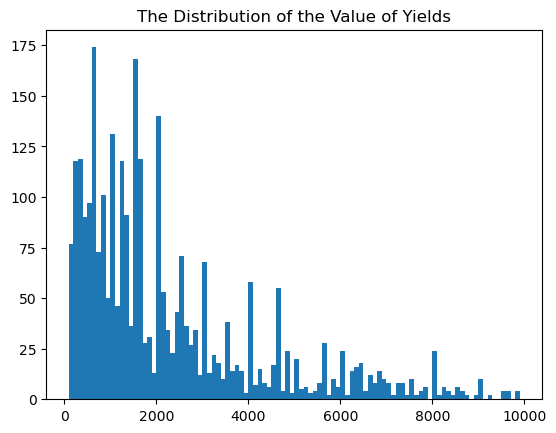

In [699]:

#  Distribution of yield
fig, ax = plt.subplots()
ax.hist(df["yield"], bins = np.arange(100, 10000, 100))
plt.title("The Distribution of the Value of Yields")

I do not find any significant outlier or inconsistent data from the yield values

Text(0.5, 1.0, 'The Distribution of the Value of Profit')

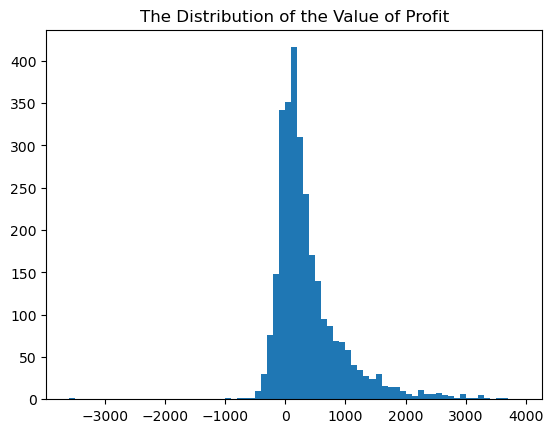

In [700]:
#  Distribution of profit
fig, ax = plt.subplots()
ax.hist(df.profit, bins = np.arange(-3600, 4000, 100))
plt.title("The Distribution of the Value of Profit")

In [701]:
df.loc[df.profit<-1000]

,country,hub,yield,profit,nue,pue,TCP,laborinput,elementalN,elementalP,...,qseed,sprice,equipments,domain,certified,useherb,useinect,applyN,applyP,applyK
2536,Sierra Leone,Bo (South) and Kenema (East),357.143,-3587.8,NaN,NaN,3668.282,55.0,0.0,0.0,...,62.5,0.225352,4.0,Lowland,Yes,No,No,No,No,No


Based on the data, the profit below -1000 tend to be an outlier. Since this value also miss the NUE and PUE value. I will drop the row for the analysis, but one may need to question why this farm has a significantly low value in profit. Since the yield value looks reasonable, it seems like there was an error in the total cost when calculating the profit.

In [702]:
# drop the outlier row for profit
df = df.loc[df.profit>-1000]
df.shape

(2906, 22)

Text(0.5, 1.0, 'The Distribution of the Value of Labor Input')

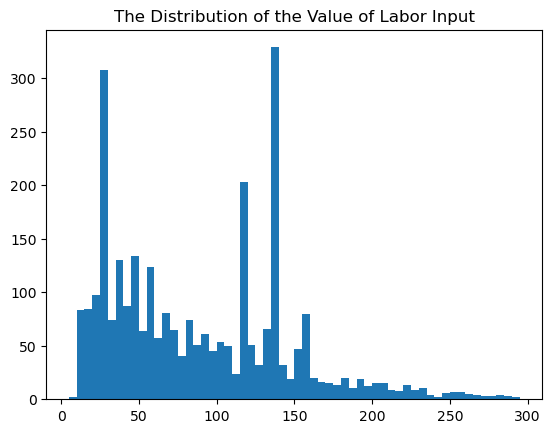

In [703]:
# Distribution of Labor input
fig, ax = plt.subplots()
ax.hist(df.laborinput, bins = np.arange(5, 300, 5))
plt.title("The Distribution of the Value of Labor Input")

I do not find any significant outlier or inconsistent data from the labor input values

Text(0.5, 1.0, 'The Initial Distribution of the NUE')

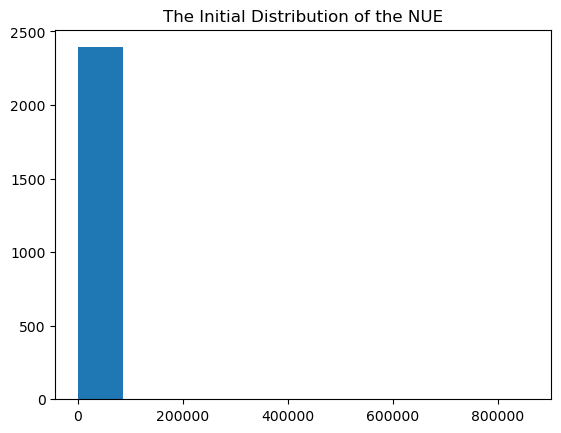

In [704]:
# Distribution of NUE
fig, ax = plt.subplots()
ax.hist(df.nue)
plt.title("The Initial Distribution of the NUE")

In [705]:
df.loc[df.nue>1000].hub.unique()

array(['Navrongo', 'Kumasi'], dtype=object)

Here, we can observe that most NUE value does not exceed more than 10,000. In fact, the average NUE value is 1314.16, and the ideal NUE value is "30-100 kg grain kg -1" (p.4, Arouna et al. 2021). In fact, all the values that has more than 1000 NUE come from Navrongo and Kumasi, the hubs in Ghana. However, the majority of the values in Navrongo and Kumasi follows the trend of the rest of the data. Particularly, I do not find a significant discontinuity of value before 10,000. Therefore, I will drop the values only over 10,000 and consider that other values are due to regional practice.

In [706]:
# drop nue value over 10000
df = df.drop(df[df.nue >10000].index)
df.shape

(2890, 22)

Text(0.5, 1.0, 'The Initial Distribution of the PUE')

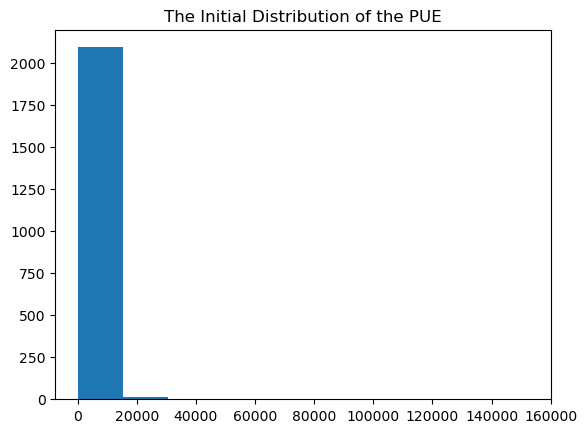

In [707]:
# Distribution of PUE
fig, ax = plt.subplots()
n, bins, patch = ax.hist(df.pue)
plt.title("The Initial Distribution of the PUE")

In [708]:
df.loc[df.pue>20000].hub.unique()

array(['Kumasi', 'Navrongo'], dtype=object)

Again, a few values in Kumasi and Navrongo is exceptionally higher than rest of the values. Since I find no continuity in pue values over 20000, I will perceive them as outliers and exclude from the analysis. However, we need to analyze why some farms in Ghana are excessively using the Nitrogen and Phosphorus in their farming in the future studies.

In [709]:
# drop pue values over 20000
df = df.drop(df.loc[df.pue>20000].index)
df.shape

(2879, 22)

In [710]:
### 1.2 Preparing Data for Analysis
## Subsetting only the attributes of interest
df_work = df[['country', 'domain', 'yield', 'profit', 'nue', 'pue', 'laborinput']]

## Dividing the attributes by rice production system
df_il = df_work[np.where(df_work.domain == "Irrigated", True, False)].copy()
print("The Shape of the Subset for the Irrigated Land: " + str(df_il.shape))

df_rl = df_work[np.where(df_work.domain == "Lowland", True, False)].copy()
print("The Shape of the Subset for the Rainfed Land: " + str(df_rl.shape))


The Shape of the Subset for the Irrigated Land: (1003, 7)
The Shape of the Subset for the Rainfed Land: (1876, 7)


In [711]:
# Subset for irrigated production system
df_il.head()

,country,domain,yield,profit,nue,pue,laborinput
392,Cote d'ivoire,Irrigated,8000.0,2283.0,16.0,153.0,116.0
393,Cote d'ivoire,Irrigated,8000.0,2283.0,16.0,153.0,116.0
415,Cote d'ivoire,Irrigated,3500.0,680.0,273.0,NaN,116.0
421,Cote d'ivoire,Irrigated,3200.0,344.0,62.0,581.0,116.0
424,Cote d'ivoire,Irrigated,3300.0,1048.0,258.0,NaN,116.0


In [712]:
# Subset for rainfed production system
df_rl.head()

,country,domain,yield,profit,nue,pue,laborinput
0,Benin,Lowland,550.0,-177.0,NaN,NaN,143.0
1,Benin,Lowland,500.0,-129.0,60.0,412.0,37.0
2,Benin,Lowland,2000.0,230.0,59.0,203.0,142.0
3,Benin,Lowland,300.0,-477.0,4.0,14.0,134.0
4,Benin,Lowland,300.0,-362.0,14.0,73.0,100.0


/var/folders/xl/m01l3f9d4wj5kbhrzm8dvp480000gn/T/ipykernel_12414/1168518409.py:12: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(["mean_lowland", "mean_irrigated", "mean_total", "Rainfed Land", "Irregrated"],


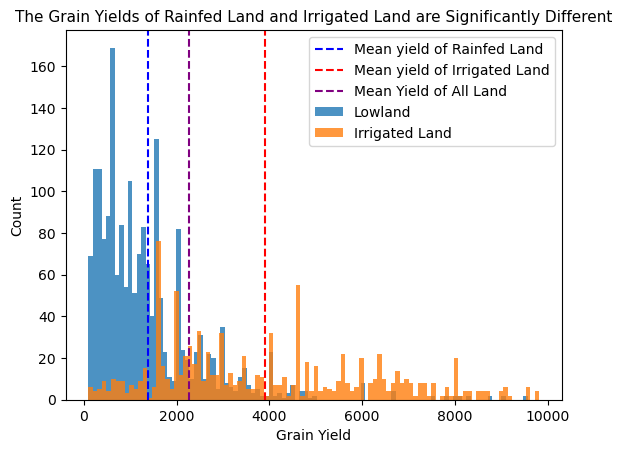

In [713]:
## Visualizing the difference in yield between rainfed and irrigated land
Lowland = plt.hist(df_rl[["yield"]],100, alpha = 0.8)
Irregrated = plt.hist(df_il[["yield"]],100, alpha = 0.8)
mean_lowland = plt.axvline(x = float(df_rl[["yield"]].mean()), c ="blue", ls = "--")
mean_irrigated = plt.axvline(x = float(df_il[["yield"]].mean()), c ="red", ls = "--")
mean_total = plt.axvline(x = float(df[["yield"]].mean()), c ="purple", ls = "--")

plt.title("The Grain Yields of Rainfed Land and Irrigated Land are Significantly Different", fontsize = 11)
plt.xlabel("Grain Yield")
plt.ylabel("Count")

plt.legend(["mean_lowland", "mean_irrigated", "mean_total", "Rainfed Land", "Irregrated"], 
            labels = ["Mean yield of Rainfed Land", "Mean yield of Irrigated Land", "Mean Yield of All Land", "Lowland", "Irrigated Land"],
            fontsize ="10")
plt.savefig("grain_yied_rainfed_irrigated.png")
plt.show()


In [714]:
### Visualizing the difference in NA values between the two system

cond_list_rl = [df_rl.nue.isna() & df_rl.pue.isna(), ~df_rl.nue.isna() & df_rl.pue.isna(), df_rl.nue.isna() & ~df_rl.pue.isna(), ~df_rl.nue.isna() & ~df_rl.pue.isna()]
choice_list_rl = ["Missing NUE & PUE" , "Missing NUE", "Missing PUE", "Not Missing"]

df_rl["missing"] = np.select(cond_list_rl, choice_list_rl)

def create_data_for_graph (data, value):
    graph = pd.DataFrame(data[data.missing == value].groupby("country").missing.size())
    values_rl = {country: number for (country, number) in zip(graph.index, graph.missing)} 
    result = [[cnt, values_rl[cnt]] if cnt in list(values_rl.keys()) else [cnt, 0] for cnt in data.country.unique() ]
    result = pd.DataFrame(result, columns=["country", value])
    return result

df_rl_nue_pue = create_data_for_graph(df_rl, "Missing NUE & PUE").sort_values(by = "country")
df_rl_nue = create_data_for_graph(df_rl, "Missing NUE").sort_values(by = "country")
df_rl_pue = create_data_for_graph(df_rl, "Missing PUE").sort_values(by = "country")
df_rl_none = create_data_for_graph(df_rl, "Not Missing").sort_values(by = "country")

In [715]:
df_rl_graph = pd.merge(df_rl_none, df_rl_nue, how="left", on="country")
df_rl_graph = pd.merge(df_rl_graph, df_rl_pue,  how="left", on="country")
df_rl_graph = pd.merge(df_rl_graph, df_rl_nue_pue,  how="left", on="country")
df_rl_graph["total"] = [df_rl_graph[df_rl_graph.columns[1:]].iloc[ind].sum() for ind in df_rl_graph.index]
df_rl_graph["prop"] = df_rl_graph["Not Missing"]/df_rl_graph["total"]
df_rl_graph

,country,Not Missing,Missing NUE,Missing PUE,Missing NUE & PUE,total,prop
0,Benin,201,6,0,41,248,0.810484
1,Cameroun,138,0,0,0,138,1.000000
2,Cote d'ivoire,131,32,0,52,215,0.609302
3,Ghana,203,0,0,0,203,1.000000
4,Madagascar,293,0,0,0,293,1.000000
5,Mali,14,5,0,6,25,0.560000
6,Nigeria,40,103,0,81,224,0.178571
7,Sierra Leone,8,3,0,212,223,0.035874
8,Tanzania,249,0,0,0,249,1.000000
9,Togo,51,1,0,6,58,0.879310


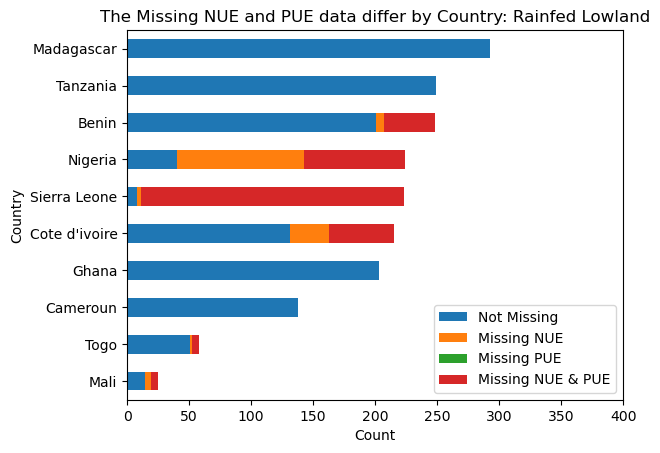

In [716]:
df_rl_graph = df_rl_graph.sort_values(by = "total").drop("total", axis ="columns").drop("prop", axis= "columns")

df_rl_graph.plot(x = "country", kind = 'barh', stacked= True,
    title = "The Missing NUE and PUE data differ by Country: Rainfed Lowland",
)
plt.legend(loc = "lower right")
plt.xlabel("Count")
plt.xlim(0,400)
plt.ylabel("Country")
plt.show()

In [717]:
cond_list = [df_il.nue.isna() & df_il.pue.isna(), ~df_il.nue.isna() & df_il.pue.isna(), df_il.nue.isna() & ~df_il.pue.isna(), ~df_il.nue.isna() & ~df_il.pue.isna()]
choice_list = ["Missing NUE & PUE" , "Missing NUE", "Missing PUE", "Not Missing"]

df_il["missing"] = np.select(cond_list, choice_list)

df_il_nue_pue = create_data_for_graph(df_il, "Missing NUE & PUE").sort_values(by = "country")
df_il_nue = create_data_for_graph(df_il, "Missing NUE").sort_values(by = "country")
df_il_pue = create_data_for_graph(df_il, "Missing PUE").sort_values(by = "country")
df_il_none = create_data_for_graph(df_il, "Not Missing").sort_values(by = "country")

In [718]:
df_il_graph = pd.merge(df_il_none, df_il_nue, how="left", on="country")
df_il_graph = pd.merge(df_il_graph, df_il_pue,  how="left", on="country")
df_il_graph = pd.merge(df_il_graph, df_il_nue_pue,  how="left", on="country")
df_il_graph["total"] = [df_il_graph[df_il_graph.columns[1:]].iloc[ind].sum() for ind in df_il_graph.index]
df_il_graph["prop"] = df_il_graph["Not Missing"]/df_il_graph["total"]

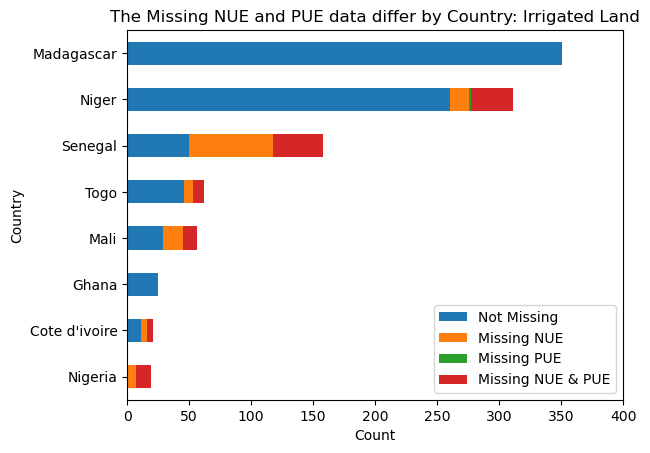

In [719]:
df_il_graph = df_il_graph.sort_values(by = "total").drop("total", axis ="columns").drop("prop", axis ="columns")

df_il_graph.plot(x = "country", kind = 'barh', stacked= True,
    title = "The Missing NUE and PUE data differ by Country: Irrigated Land",
)
plt.legend(loc = "lower right")
plt.xlabel("Count")
plt.xlim(0,400)
plt.ylabel("Country")
plt.show()

In [720]:
###################################
### 2. Preparing Target Array & Feature Matrix 
###################################

### 1) Dropping all missing values
## Drop NAs
# drop all NAs from the dataframe
df_il_nona = df_il.dropna()
df_rl_nona = df_rl.dropna()

## Feature Matrix
# Feature Matrix for Irrigated Land
X_il= df_il_nona.copy().drop(['country', 'domain', 'missing', 'yield'], axis = 1)
# Feature Matrix for Rainfed Lowland
X_rl = df_rl_nona.copy().drop(['country', 'domain', 'missing', 'yield'], axis = 1)

In [721]:
## Target Array
def find_yield_group (data, country_given, yield_given):
    """
     This Function classifies each row by their grain yield
     Input: 
        - data (dataframe): dataframe used to set the standard
        - country_given (string): the country of the observation
        - yield_given (numeric): the grain yield value of the observation
     Return: -1, 0, 1 (numeric value that each represents the low 10%, mid 80%, and the high 10% of the yield)    
    """
    low_10 = np.percentile(data['yield'][data['country'] == country_given], 10)
    middle_80 = np.percentile(data['yield'][data['country'] == country_given], 80)
    if yield_given <= low_10 :
        return -1
    elif (yield_given > low_10) & (yield_given <= middle_80):
        return 0
    elif yield_given > middle_80:
        return 1
    else: return np.nan

# Apply find_yield_group to create a target array
y_il = df_il_nona.apply(lambda row: find_yield_group(df_il_nona, row['country'], row['yield']), axis = 1)
y_rl = df_rl_nona.apply(lambda row: find_yield_group(df_rl_nona, row['country'], row['yield']), axis = 1)

In [722]:
# Concat the irrigated and the rainfed lowlands dataset
total_X = pd.concat([X_il, X_rl])
total_y = pd.concat([y_il, y_rl])

In [723]:
#Standardizaton
SScaler = StandardScaler()
total_X = pd.DataFrame(SScaler.fit_transform(total_X), columns = total_X.columns)

In [724]:
### 2) Without dropping the missing values
## Features Matrix without dropping NAs
X_il_with_na = df_il.drop(['country', 'domain', 'missing', 'yield'], axis = 1) 
X_rl_with_na = df_rl.drop(['country', 'domain', 'missing', 'yield'], axis = 1)

In [725]:
## Target Array
y_il_with_na = df_il.apply(lambda row: find_yield_group(df_il, row['country'], row['yield']), axis = 1)
y_rl_with_na = df_rl.apply(lambda row: find_yield_group(df_rl, row['country'], row['yield']), axis = 1)

In [726]:
# Concat the irrigated and the rainfed lowlands dataset
X_with_na = pd.concat([X_il_with_na, X_rl_with_na])
y_with_na = pd.concat([y_il_with_na, y_rl_with_na])

In [727]:
#Standardizaton
SScaler_with_na = StandardScaler()
X_with_na = pd.DataFrame(SScaler.fit_transform(X_with_na), columns = X_with_na.columns)

In [728]:
# KNN Imputation on the feature matrix
imputer_X = KNNImputer(n_neighbors=4)
X_imp= imputer_X.fit_transform(X_with_na)


In [729]:
###################################
### 3. K Nearest Neighbor
###################################

### Without NA values
## Train Test Split
Xtrain, Xtest, ytrain, ytest = train_test_split(total_X, total_y, test_size = 0.2, random_state = 235)

In [730]:
## KNN application
knn = KNeighborsClassifier(n_neighbors= 4)
knn.fit(Xtrain, ytrain)

# Accuracy Score
knn.score(Xtest, ytest)

0.7261904761904762

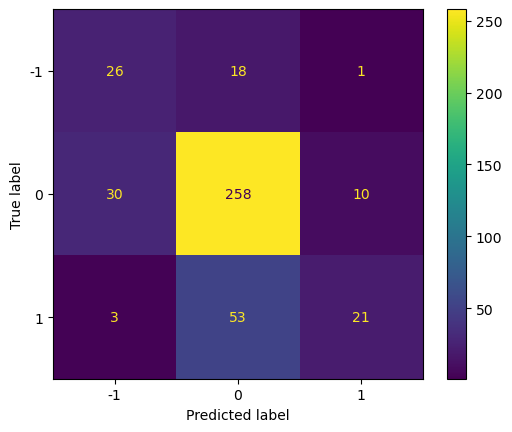

In [731]:
# Confusion Matrix
ypredict= knn.predict(Xtest)
cm= confusion_matrix(ytest, ypredict)
cm_graph = ConfusionMatrixDisplay(cm, display_labels= knn.classes_)
cm_graph.plot()
plt.show()

In [732]:
# Dataframe to save the precision, recall, f_score, and jaccard
total_score = pd.DataFrame(
    columns= ["model", "imputation", "group", "precision", "recall", "f_beta"
    #, "jaccard"
    ]
)

In [733]:
## Calculate precision, recall, f_score, and jaccard
# in order to calculate the value for each label, we compared the accuracy between a label vs all other labels

def calculate_score (model, imputation, test, predict):
    """
    Calculate the precision, recall, f-beta, jaccard score
    Parameter: model (string), imputation(string), test(dataframe), predict(dataframe)
    Return : label_score(dataframe)
    """
    label = [-1, 0, 1]
    score = pd.DataFrame(
        columns= ["model", "imputation", "group", "precision", "recall", "f_beta" 
    #   , "jaccard"
        ]
    )
    for group in label:
        binary_test = [1 if value == group else 0 for value in test]
        binary_predict = [1 if prediction == group else 0 for prediction in predict]
        precision_total, recall_total, fbeta_score_total, support_total = precision_recall_fscore_support(binary_test, binary_predict, average = "macro")
        #jaccard_total = jaccard_score(binary_test, binary_predict)

        if group == -1:
            category = "low" 
        elif group == 0:
            category = "middle"
        else:
            category = "high"

        label_score = pd.DataFrame([
            {
            "model" : model,
            "imputation": imputation, 
            "group" : category,
            "precision": precision_total,
            "recall": recall_total, 
            "f_beta": fbeta_score_total,
            #"jaccard": jaccard_total
            }
        ])
        score = pd.concat([score, label_score])
    return score

total_score = pd.concat([total_score, calculate_score("KNN", "Drop", ytest, ypredict)])
total_score
    

,model,imputation,group,precision,recall,f_beta
0,KNN,Drop,low,0.694023,0.744889,0.714674
0,KNN,Drop,middle,0.672317,0.641902,0.650920
0,KNN,Drop,high,0.755960,0.620329,0.646833


In [734]:
# Hyperparameter Tuning 
neighborhood_range = np.arange(1,10)
train_scores, test_scores = validation_curve(knn, Xtrain, ytrain, param_name='n_neighbors',
                                            param_range= neighborhood_range, cv=10)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

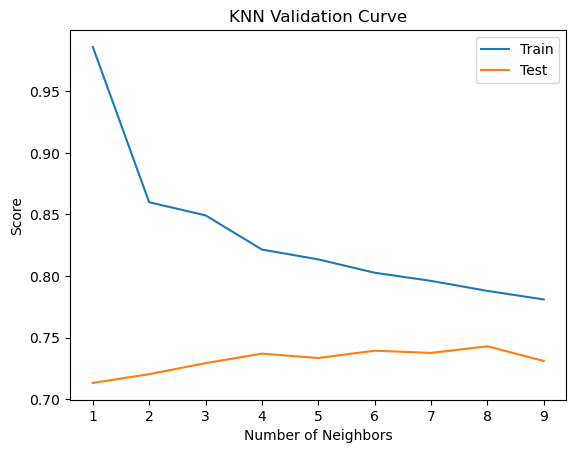

In [735]:
neighbor_max = np.arange(1,10)
fig1 = plt.figure()
plt.plot(neighbor_max, train_mean, label='Train')
plt.plot(neighbor_max, test_mean, label='Test')
plt.xlabel('Number of Neighbors')
plt.ylabel('Score')
plt.title('KNN Validation Curve')
plt.legend()
plt.show()
fig1.savefig('validation_curve_knn_il.png')

In [736]:
### KNN after Imputation
## Train Test Split
X_imp_data = pd.DataFrame(X_imp, columns = Xtest.columns) 
Xtrain_imp, Xtest_imp, ytrain_imp, ytest_imp = train_test_split(X_imp_data, y_with_na.values, test_size = 0.2, random_state = 235)

## KNN
knn_imp = KNeighborsClassifier(n_neighbors= 4)
knn_imp.fit(Xtrain_imp, ytrain_imp)
knn_imp.score(Xtest_imp, ytest_imp)

0.7274305555555556

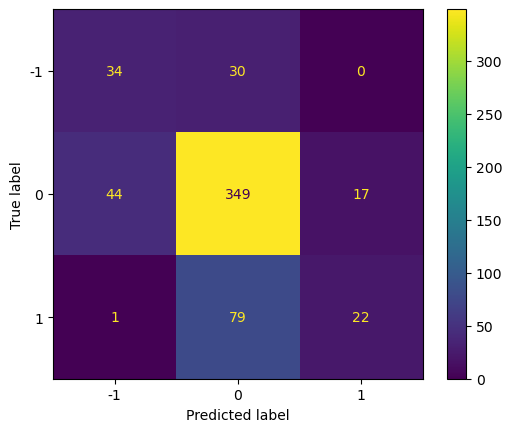

In [737]:
# Confusion Matrix
ypredict_imp = knn.predict(Xtest_imp)
cm2= confusion_matrix(ytest_imp, ypredict_imp)
cm2_graph = ConfusionMatrixDisplay(cm2, display_labels= knn.classes_)
cm2_graph.plot()

In [738]:
## Calculate precision, recall, f_score, and jaccard
# in order to calculate the value for each label, we compared the accuracy between a label vs all other labels
total_score = pd.concat([total_score, calculate_score("KNN", "KNN_Imputation", ytest_imp, ypredict_imp)])
total_score

,model,imputation,group,precision,recall,f_beta
0,KNN,Drop,low,0.694023,0.744889,0.714674
0,KNN,Drop,middle,0.672317,0.641902,0.650920
0,KNN,Drop,high,0.755960,0.620329,0.646833
0,KNN,KNN_Imputation,low,0.685009,0.721680,0.700597
0,KNN,KNN_Imputation,middle,0.622530,0.597297,0.602778
0,KNN,KNN_Imputation,high,0.707563,0.589911,0.608056


In [739]:
###################################
### 4. Parametric
###################################

In [740]:
### Without NA values
## Train Test Split
Xtrain_log_drop, Xtest_log_drop, ytrain_log_drop, ytest_log_drop = train_test_split(total_X, total_y, test_size = 0.2, random_state = 235)

In [741]:
## Logistic Regression
lgr = LogisticRegression(multi_class = 'multinomial')
lgr.fit(Xtrain_log_drop, ytrain_log_drop)
lgr.score(Xtest_log_drop, ytest_log_drop)

0.7428571428571429

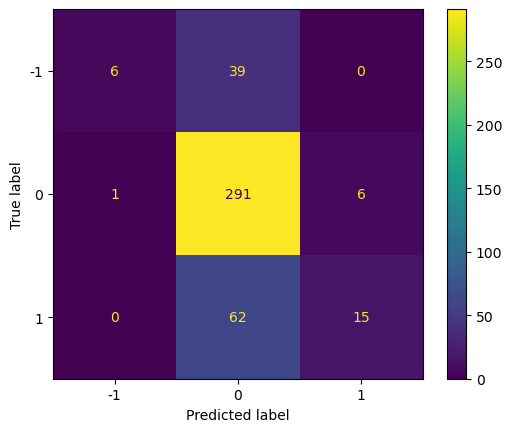

In [742]:
# Confusion Matrix
ypredict_log_drop = lgr.predict(Xtest_log_drop)
cm3= confusion_matrix(ytest_log_drop, ypredict_log_drop)
cm3_graph = ConfusionMatrixDisplay(cm3, display_labels= lgr.classes_)
cm3_graph.plot()
plt.show()

In [743]:
## Calculate precision, recall, f_score, and jaccard
# in order to calculate the value for each label, we compared the accuracy between a label vs all other labels
total_score = pd.concat([total_score, calculate_score("Logistic", "Drop", ytest_log_drop, ypredict_log_drop)])
total_score

,model,imputation,group,precision,recall,f_beta
0,KNN,Drop,low,0.694023,0.744889,0.714674
0,KNN,Drop,middle,0.672317,0.641902,0.650920
0,KNN,Drop,high,0.755960,0.620329,0.646833
0,KNN,KNN_Imputation,low,0.685009,0.721680,0.700597
0,KNN,KNN_Imputation,middle,0.622530,0.597297,0.602778
0,KNN,KNN_Imputation,high,0.707563,0.589911,0.608056
0,Logistic,Drop,low,0.881356,0.565333,0.590004
0,Logistic,Drop,middle,0.746173,0.574321,0.561739
0,Logistic,Drop,high,0.779449,0.588656,0.607239


In [744]:
### KNN Imputation
## Train Test Split
Xtrain_log, Xtest_log, ytrain_log, ytest_log = train_test_split(X_imp, y_with_na, test_size=0.2, random_state = 235)

In [745]:
## Logistic Regression
lgr = LogisticRegression(multi_class = 'multinomial')
lgr.fit(Xtrain_log, ytrain_log)
lgr.score(Xtest_log, ytest_log)

0.7309027777777778

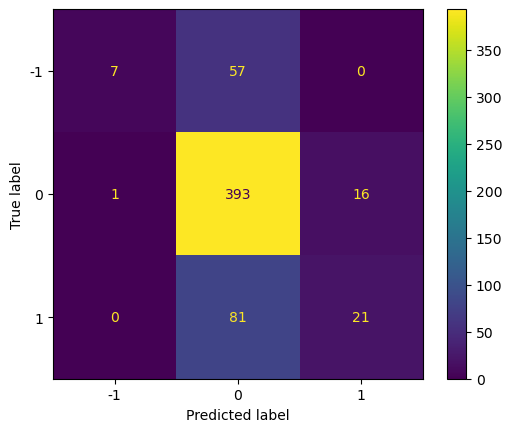

In [746]:
# Confusion Matrix
ypredict_log = lgr.predict(Xtest_log)
cm4= confusion_matrix(ytest_log, ypredict_log)
cm4_graph = ConfusionMatrixDisplay(cm4, display_labels= knn.classes_)
cm4_graph.plot()
plt.show()

In [747]:
## Calculate precision, recall, f_score, and jaccard
# in order to calculate the value for each label, we compared the accuracy between a label vs all other labels
total_score = pd.concat([total_score, calculate_score("Logistic", "KNN_Imputation", ytest_log, ypredict_log)]).reset_index(drop = True)
total_score = total_score.round(2)
total_score


,model,imputation,group,precision,recall,f_beta
0,KNN,Drop,low,0.69,0.74,0.71
1,KNN,Drop,middle,0.67,0.64,0.65
2,KNN,Drop,high,0.76,0.62,0.65
3,KNN,KNN_Imputation,low,0.69,0.72,0.70
4,KNN,KNN_Imputation,middle,0.62,0.60,0.60
5,KNN,KNN_Imputation,high,0.71,0.59,0.61
6,Logistic,Drop,low,0.88,0.57,0.59
7,Logistic,Drop,middle,0.75,0.57,0.56
8,Logistic,Drop,high,0.78,0.59,0.61
9,Logistic,KNN_Imputation,low,0.89,0.55,0.57


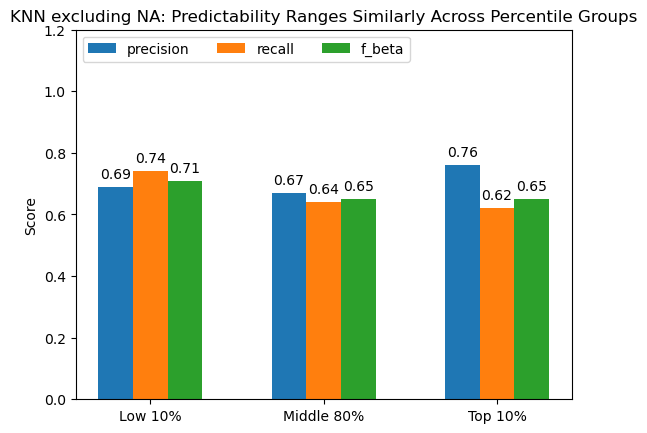

In [748]:
### Visualize the Scores
## KNN Drop

group = ("Low 10%", "Middle 80%", "Top 10%")
score_graph = total_score.iloc[[0,1,2]][['precision', 'recall', 'f_beta']]

x = np.arange(len(group))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots()

for attribute, measurement in score_graph.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=4)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('KNN excluding NA: Predictability Ranges Similarly Across Percentile Groups')
ax.set_xticks(x + width, group)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1.2)

plt.show()

(0.0, 1.0)

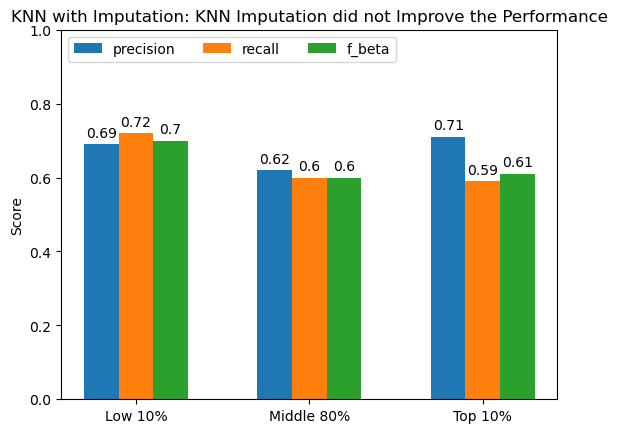

In [749]:
## KNN Imputation

group = ("Low 10%", "Middle 80%", "Top 10%")
score_graph = total_score.iloc[[3,4,5]][['precision', 'recall', 'f_beta']]

x = np.arange(len(group))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots()

for attribute, measurement in score_graph.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('KNN with Imputation: KNN Imputation did not Improve the Performance')
ax.set_xticks(x + width, group)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1)


(0.0, 1.0)

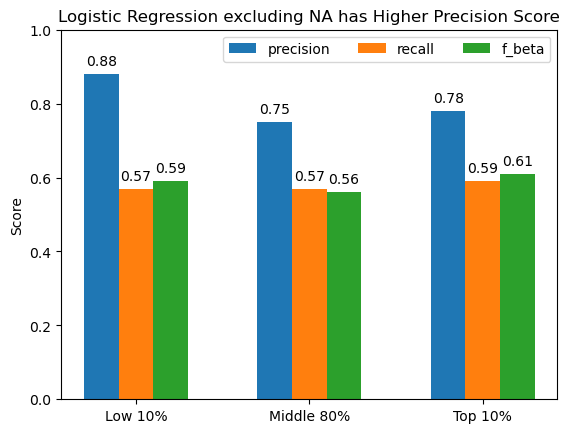

In [750]:
## Logistic Regression Drop

group = ("Low 10%", "Middle 80%", "Top 10%")
score_graph = total_score.iloc[[6,7,8]][['precision', 'recall', 'f_beta']]

x = np.arange(len(group))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots()

for attribute, measurement in score_graph.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=4)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Logistic Regression excluding NA has Higher Precision Score')
ax.set_xticks(x + width, group)
ax.legend(loc='upper right', ncols=3)
ax.set_ylim(0, 1)


(0.0, 1.0)

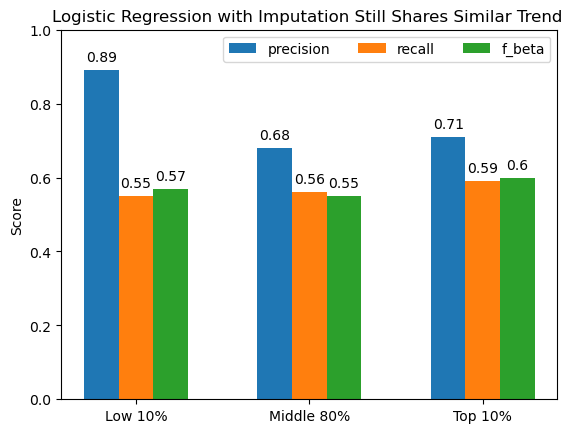

In [751]:
## Logistic Regression & Imputation

group = ("Low 10%", "Middle 80%", "Top 10%")
score_graph = total_score.iloc[[9,10,11]][['precision', 'recall', 'f_beta']]

x = np.arange(len(group))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots()

for attribute, measurement in score_graph.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=4)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Logistic Regression with Imputation Still Shares Similar Trend ')
ax.set_xticks(x + width, group)
ax.legend(loc='upper right', ncols=3)
ax.set_ylim(0, 1)
